In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv('/kaggle/input/trum-tweet/trum_tweet_sentiment_analysis.csv')

In [5]:
df.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0
2,Trump protests: LGBTQ rally in New York https:...,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0


In [6]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text) # Remove mentions/hashtags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = re.sub(r'\d+', '', text) # Remove numbers
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [7]:
# Apply cleaning
df['cleaned_text'] = df['text'].astype(str).apply(preprocess_text)
# Check cleaned data
df[['text', 'cleaned_text', 'Sentiment']].head()

,text,cleaned_text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,rt trump draining swamp taxpayer dollar trip a...,0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,icymi hacker rig fm radio station play antitru...,0
2,Trump protests: LGBTQ rally in New York https:...,trump protest lgbtq rally new york bbcworld via,1
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",hi im pier morgan david beckham awful donald t...,0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,rt tech firm suing buzzfeed publishing unverif...,0


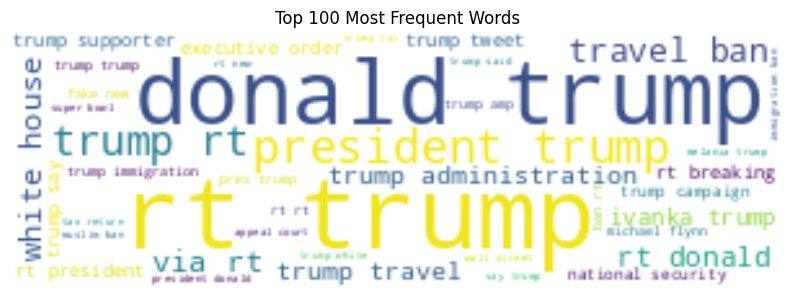

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# --- Visualization: Word Cloud (Top 100 Words) ---
all_words = ' '.join(df['cleaned_text'])
# Generate WordCloud with only top 100 words
wordcloud = WordCloud(
width=300,
height=100,
background_color='white',
max_words=100 # Limit to top 100 words
).generate(all_words)
# Plot settings
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
# Split FIRST (before tokenization)
X_train, X_test, y_train, y_test = train_test_split(
df['cleaned_text'], # Features (text)
df['Sentiment'], # Labels
test_size=0.2,
random_state=42
)

In [10]:
# Initialize tokenizer
vocab_size = 10000
oov_token = '<OOV>'
embed_dim = 128
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# Fit on training data
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq  = tokenizer.texts_to_sequences(X_test)


In [11]:
seq_lengths = [len(seq) for seq in train_seq]
max_len = int(np.percentile(seq_lengths, 95))


In [12]:
X_train_pad = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(test_seq,  maxlen=max_len, padding='post', truncating='post')


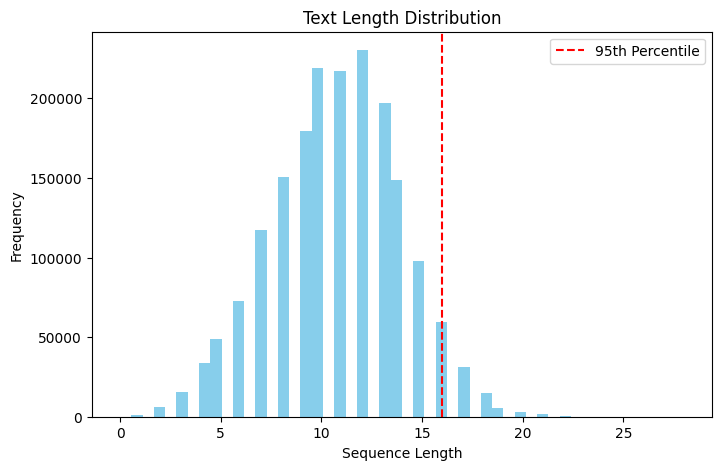

In [13]:
X_seq = tokenizer.texts_to_sequences(df['cleaned_text'])
seq_lengths = [len(seq) for seq in X_seq]
plt.figure(figsize=(8, 5))
plt.hist(seq_lengths, bins=50, color='skyblue')
plt.title('Text Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(np.percentile(seq_lengths, 95), color='red', linestyle='dashed', label='95th Percentile'
)
plt.legend()
plt.show()

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
# RNN model
def build_rnn(vocab_size, embed_dim, input_len):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_len),
        SimpleRNN(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
def build_lstm(vocab_size, embed_dim, input_len):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=input_len),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [16]:
rnn_model  = build_rnn(vocab_size, embed_dim, max_len)
lstm_model = build_lstm(vocab_size, embed_dim, max_len)

rnn_model.summary()
lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1745379626.365424      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745379626.366065      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
rnn_ckpt  = ModelCheckpoint('best_rnn.keras',  monitor='val_accuracy', save_best_only=True)
lstm_ckpt = ModelCheckpoint('best_lstm.keras', monitor='val_accuracy', save_best_only=True)

# Train RNN
history_rnn = rnn_model.fit(
    X_train_pad, y_train,
    epochs=10, batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, rnn_ckpt]
)

# Train LSTM
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    epochs=10, batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, lstm_ckpt]
)

Epoch 1/10


I0000 00:00:1745380484.633191     102 service.cc:148] XLA service 0x7b90cc0072e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745380484.635375     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745380484.635398     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745380485.211877     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


   53/20814 ━━━━━━━━━━━━━━━━━━━━ 1:01 3ms/step - accuracy: 0.6561 - loss: 0.6399

I0000 00:00:1745380486.629486     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20814/20814 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.9161 - loss: 0.2087 - val_accuracy: 0.9544 - val_loss: 0.1269
Epoch 2/10
20814/20814 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9616 - loss: 0.1088 - val_accuracy: 0.9605 - val_loss: 0.1119
Epoch 3/10
20814/20814 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9688 - loss: 0.0904 - val_accuracy: 0.9618 - val_loss: 0.1119
Epoch 4/10
20814/20814 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9716 - loss: 0.0828 - val_accuracy: 0.9632 - val_loss: 0.1086
Epoch 5/10
20814/20814 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9735 - loss: 0.0775 - val_accuracy: 0.9602 - val_loss: 0.1181
Epoch 6/10
20814/20814 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9751 - loss: 0.0741 - val_accuracy: 0.9629 - val_loss: 0.1117
Epoch 7/10
20814/20814 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9751 - loss: 0.0743 - val_accuracy: 0.9639 - val_loss: 0.1103
Epoch 1/10
20814/20814 ━━━━━━━━━━━━━━━━━━━━ 94s 4ms/step - accuracy: 0.9227 - lo

In [19]:
# Evaluate on test set
rnn_eval  = rnn_model.evaluate(X_test_pad, y_test)
lstm_eval = lstm_model.evaluate(X_test_pad, y_test)
print(f"RNN Test Loss/Acc: {rnn_eval}")
print(f"LSTM Test Loss/Acc: {lstm_eval}")

# Predictions and Classification Report for LSTM
y_pred_prob = lstm_model.predict(X_test_pad)
# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)



11564/11564 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9625 - loss: 0.1090
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9725 - loss: 0.0830
RNN Test Loss/Acc: [0.10820833593606949, 0.962861955165863]
LSTM Test Loss/Acc: [0.0829257145524025, 0.9722154140472412]
11564/11564 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Confusion Matrix (LSTM):


NameError: name 'confusion_matrix' is not defined

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Confusion Matrix (LSTM):")
print(confusion_matrix(y_test, y_pred))
print("Classification Report (LSTM):")
print(classification_report(y_test, y_pred))

Confusion Matrix (LSTM):
[[243875   4688]
 [  5593 115869]]
Classification Report (LSTM):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    248563
           1       0.96      0.95      0.96    121462

    accuracy                           0.97    370025
   macro avg       0.97      0.97      0.97    370025
weighted avg       0.97      0.97      0.97    370025



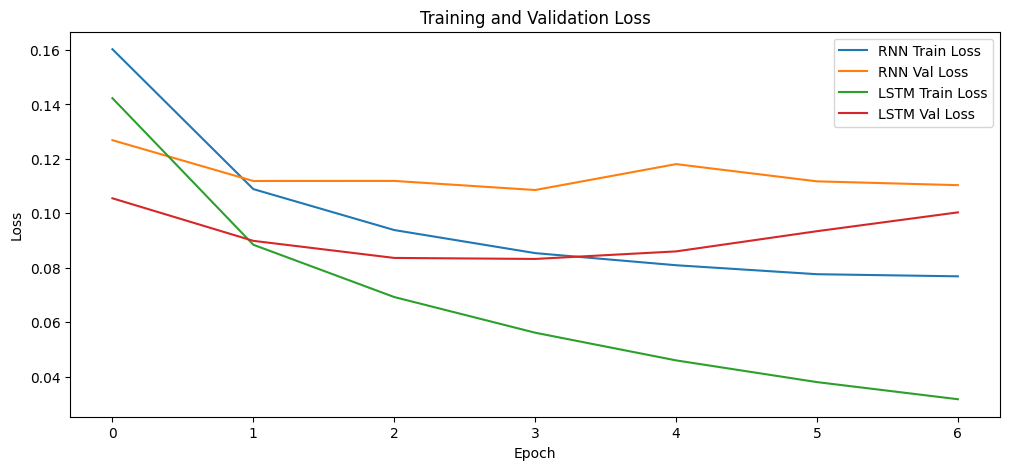

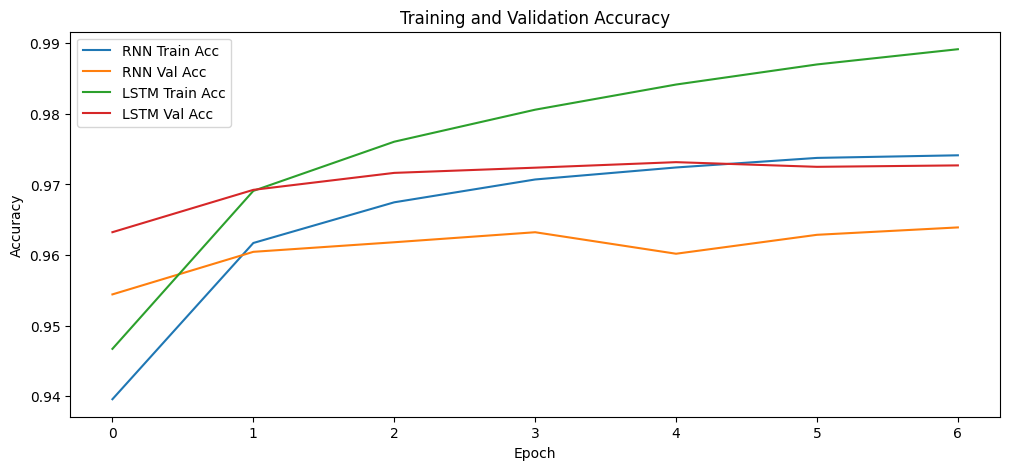

In [22]:
plt.figure(figsize=(12,5))
plt.plot(history_rnn.history['loss'], label='RNN Train Loss')
plt.plot(history_rnn.history['val_loss'], label='RNN Val Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12,5))
plt.plot(history_rnn.history['accuracy'], label='RNN Train Acc')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val Acc')
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Acc')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
import tkinter as tk
from tkinter import messagebox
# Function to predict sentiment based on user input
def predict_sentiment_gui():
    user_input = entry.get() # Get the text input from the user
    if user_input.strip() == "":
        messagebox.showwarning("Input Error", "Please enter a tweet for prediction!")
    return
    # Predict sentiment using the trained model
    prediction = predict_sentiment(user_input)
    # Display the result in the label
    result_label.config(text=f"Predicted Sentiment: {prediction}")
# Create the main window
root = tk.Tk()
root.title("Twitter Sentiment Predictor")
# Label for instructions
instruction_label = tk.Label(root, text="Enter a tweet to predict its sentiment:", font=("Arial",
14))
instruction_label.pack(pady=10)
# Entry box for user to input a tweet
entry = tk.Entry(root, width=50, font=("Arial", 12))
entry.pack(pady=10)
# Predict button to trigger sentiment prediction
predict_button = tk.Button(root, text="Predict Sentiment", font=("Arial", 12), command=
predict_sentiment_gui)
predict_button.pack(pady=10)
# Label to display the predicted sentiment
result_label = tk.Label(root, text="", font=("Arial", 14), fg="blue")
result_label.pack(pady=10)
# Run the Tkinter main loop
root.mainloop()

TclError: no display name and no $DISPLAY environment variable